In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Load and prepare the dataset
df = pd.read_csv('../csv/RDC_Inventory_Monthly_Core_Metrics_Country_History.csv')
df.dropna(inplace=True)
df = df.iloc[::-1].reset_index(drop=True)

# Feature engineering: Add new features if possible
# Example: Extract year and month from 'month_date_yyyymm'
df['year'] = df['month_date_yyyymm'].astype(str).str[:4].astype(int)
df['month'] = df['month_date_yyyymm'].astype(str).str[4:6].astype(int)

# Add lag features
df['lag_1'] = df['median_listing_price_mm'].shift(1)
df['lag_2'] = df['median_listing_price_mm'].shift(2)
df['lag_3'] = df['median_listing_price_mm'].shift(3)
df.dropna(inplace=True)  # Drop rows with NaN values resulting from lagging

features = ['year', 'month','lag_1', 'lag_2', 'lag_3']

# Define features and target variable
X = df[features]  # Features (updated to use year and month)
y = df['median_listing_price_mm']  # Target variable

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

# Train the model with cross-validation
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Make predictions on the test set
predictions = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, predictions)
mse = mean_squared_error(y_test, predictions)
print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)

# Function to make a specific prediction
def predict_price(year, month, lag_1, lag_2, lag_3):
    new_data = pd.DataFrame({
        'year': [year], 
        'month': [month],
        'lag_1': [lag_1], 
        'lag_2': [lag_2], 
        'lag_3': [lag_3]
    })
    new_data_scaled = scaler.transform(new_data)
    predicted_price = model.predict(new_data_scaled)
    return predicted_price[0]

predicted_list = []
for i in range(0, len(df[['month_date_yyyymm', 'median_listing_price_mm', 'lag_1', 'lag_2', 'lag_3']])):
    data = df[['month_date_yyyymm', 'median_listing_price_mm', 'lag_1', 'lag_2', 'lag_3']].iloc[i]
    year = int(data['month_date_yyyymm'][:4])
    month = int(data['month_date_yyyymm'][4:6])
    predicted_list.append(predict_price(year, month, data["lag_1"], data["lag_2"], data["lag_3"]))

df["predicted"] = predicted_list
print(df[['month_date_yyyymm', 'median_listing_price_mm', 'predicted']])

# Example usage
new_year = 2023
new_month = 12
predicted_price = predict_price(new_year, new_month, -0.0012, 0.0147, 0.0226)
print(f"Predicted median listing price for {new_year}-{new_month:02d}: {predicted_price}")

Mean Absolute Error (MAE): 0.007739562499999997
Mean Squared Error (MSE): 0.00014722450143749978
   month_date_yyyymm  median_listing_price_mm  predicted
3             201710                   0.0000  -0.002955
4             201711                  -0.0020  -0.005601
5             201712                  -0.0165  -0.015018
6             201801                  -0.0006  -0.000967
7             201802                   0.0212   0.018538
..               ...                      ...        ...
77            202312                  -0.0238  -0.021028
78            202401                  -0.0012  -0.000194
79            202402                   0.0147   0.016632
80            202403                   0.0226   0.022090
81            202404                   0.0119   0.017439

[79 rows x 3 columns]
Predicted median listing price for 2023-12: -0.01749300000000001


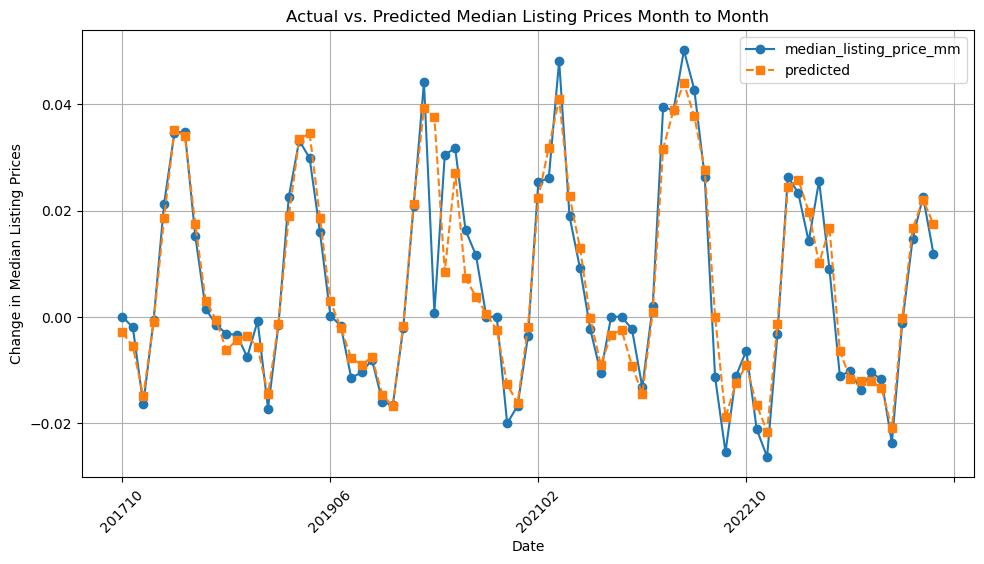

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))  # Increase figure size
ax = df.plot(x='month_date_yyyymm', y='median_listing_price_mm', kind='line', marker='o', linestyle='-', title='Actual vs. Predicted Median Listing Prices Month to Month', ax=plt.gca())
df.plot(x='month_date_yyyymm', y='predicted', kind='line', marker='s', linestyle='--', ax=ax)  # Different marker and linestyle for distinction
# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust tick frequency on x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust this number as needed

# Adjust tick frequency on y-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust this number as needed

# Add padding around the plot elements
plt.tight_layout(pad=2.0)

# Show grid
plt.grid(True)

# Show the plot
plt.xlabel('Date')
plt.ylabel('Change in Median Listing Prices')
plt.show()

In [4]:
# Recursive prediction function
def forecast_future_prices(start_year, start_month, steps):
    # Initialize the starting point with the most recent data
    last_known_data = df.iloc[-1]
    lag_1 = last_known_data['median_listing_price_mm']
    lag_2 = df.iloc[-2]['median_listing_price_mm']
    lag_3 = df.iloc[-3]['median_listing_price_mm']

    future_predictions = []

    for step in range(steps):
        # Calculate the next month and year
        current_month = (start_month + step - 1) % 12 + 1
        current_year = start_year + (start_month + step - 1) // 12
        
        predicted_price = predict_price(current_year, current_month, lag_1, lag_2, lag_3)
        future_predictions.append({
            'year': current_year,
            'month': current_month,
            'predicted_price': predicted_price
        })

        # Update lags for next prediction
        lag_3 = lag_2
        lag_2 = lag_1
        lag_1 = predicted_price

    return pd.DataFrame(future_predictions)

# Forecast for the next 12 months
start_year = 2024
start_month = 4
steps = 13

future_prices = forecast_future_prices(start_year, start_month, steps)
print(future_prices)

    year  month  predicted_price
0   2024      4         0.011501
1   2024      5         0.008820
2   2024      6         0.009145
3   2024      7        -0.006713
4   2024      8        -0.011504
5   2024      9        -0.012762
6   2024     10        -0.012301
7   2024     11        -0.016269
8   2024     12        -0.020922
9   2025      1         0.000348
10  2025      2         0.016660
11  2025      3         0.023310
12  2025      4         0.017749


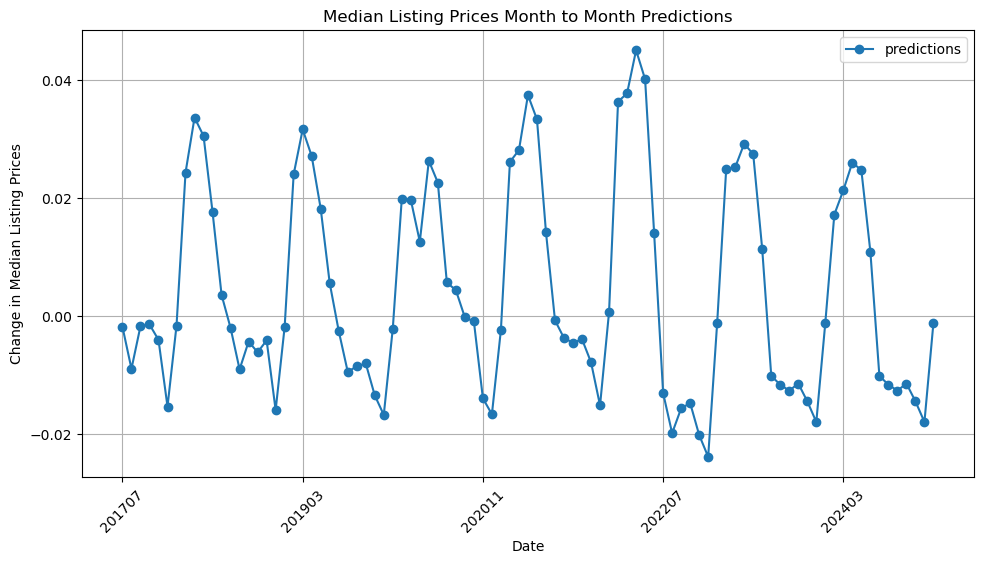

In [10]:
predictions = []
date = []
year = 2017
month = 7

while year != 2025 and month != 1:
    if month == 13:
        month = 1
        year += 1
    predictions.append(float(format(predict_price(year, month), ".4f")))
    str_year = str(year)
    str_month = str(month) if month > 9 else '0' + str(month)
    date.append(str_year + str_month)
    month += 1

df_predictions = pd.DataFrame({'date': date, 'predictions': predictions})

plt.figure(figsize=(10, 6))  # Increase figure size
ax = df_predictions.plot(x='date', y='predictions', kind='line', marker='o', linestyle='-', title='Median Listing Prices Month to Month Predictions', ax=plt.gca())

# Rotate x-axis labels
plt.xticks(rotation=45)

# Adjust tick frequency on x-axis
ax.xaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust this number as needed

# Adjust tick frequency on y-axis
ax.yaxis.set_major_locator(plt.MaxNLocator(5))  # Adjust this number as needed

# Add padding around the plot elements
plt.tight_layout(pad=2.0)

# Show grid
plt.grid(True)

# Show the plot
plt.xlabel('Date')
plt.ylabel('Change in Median Listing Prices')
plt.show()